<a href="https://colab.research.google.com/github/AchinthaThennakoon/L4S2-FYP-UOM/blob/main/Final_v1/CNN_model_selecting/custom_CNN/Custom_CNN_measure_performance(individual_depths).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib

In [ ]:
import pandas as pd

In [ ]:
import pickle

In [ ]:
import json
import os

# loading data set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/FYP_code/Disease_dataset/Corn (Maize)'
train_ds_path = 'Train'
val_ds_path = 'Val'
test_ds_path = 'Test'

In [ ]:
path = os.path.join(dataset_path, train_ds_path)
path

'/content/drive/MyDrive/Colab Notebooks/FYP_code/Disease_dataset/Corn (Maize)/Train'

In [ ]:
train_dir = os.path.join(dataset_path, 'Train')
validation_dir = os.path.join(dataset_path, 'Val')
test_dir = os.path.join(dataset_path, 'Test')

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [ ]:
train_ds =  keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
    )

Found 7326 files belonging to 4 classes.


In [ ]:
val_ds =  keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
    )

Found 1070 files belonging to 4 classes.


In [ ]:
test_ds =  keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
    )

Found 763 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names
class_names

['Cercospora Leaf Spot', 'Common Rust', 'Healthy', 'Northern Leaf Blight']

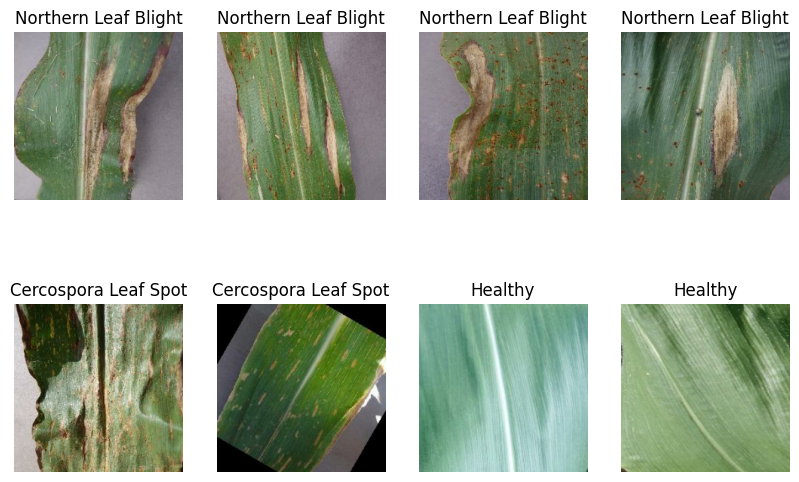

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# parameters and augmentations

In [ ]:
resize_and_rescale = keras.Sequential([
  keras.layers.Rescaling(1./127.5, offset=-1),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2)
])

In [ ]:
no_of_classes = len(class_names)

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [ ]:
epochs = 150

# model

In [ ]:
def create_model(depth):
    model = tf.keras.models.Sequential()
    model.add(resize_and_rescale)
    model.add(data_augmentation)

    model.add(layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    for _ in range(depth - 1):
        model.add(layers.Conv2D(32, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(no_of_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    return model

## Early stopping

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                                                    monitor='val_loss',
                                                    mode='min',
                                                    patience=5,
                                                    restore_best_weights=True
                                                    )

# Training, Save and evaluation functions

In [ ]:
def train_and_save_history(depth, train_data, val_data, test_data, history_dir):
    model = create_model(depth)
    history = model.fit(
                          train_data,
                          batch_size=BATCH_SIZE,
                          validation_data=val_data,
                          verbose=1,
                          epochs=epochs,
                          callbacks=[early_stopping]
                          )
    evaluation = model.evaluate(test_data)

    # Combine history and evaluation metrics
    history_dict = history.history
    history_dict['test_loss'] = evaluation[0]
    history_dict['test_accuracy'] = evaluation[1]

    history_path = os.path.join(history_dir, f'history_depth_{depth}.json')
    with open(history_path, 'w') as f:
        json.dump(history_dict, f)

In [ ]:
def load_history(depth, history_dir):
    history_path = os.path.join(history_dir, f'history_depth_{depth}.json')
    with open(history_path, 'r') as f:
        history = json.load(f)
    return history

# Measure performance vs Layers

In [ ]:
history_path ='/content/drive/MyDrive/Colab Notebooks/FYP_code/Final_v1/CNN_model_selecting/custom_CNN/history'

## depth 1

In [ ]:
train_and_save_history(depth=1, train_data=train_ds, val_data=val_ds, test_data=test_ds,history_dir=history_path)

Epoch 1/150
229/229 [==============================] - 510s 2s/step - loss: 1.0411 - accuracy: 0.8324 - val_loss: 0.2316 - val_accuracy: 0.8963
Epoch 2/150
229/229 [==============================] - 34s 145ms/step - loss: 0.2189 - accuracy: 0.9162 - val_loss: 0.2284 - val_accuracy: 0.9121
Epoch 3/150
229/229 [==============================] - 34s 143ms/step - loss: 0.1541 - accuracy: 0.9429 - val_loss: 0.1548 - val_accuracy: 0.9308
Epoch 4/150
229/229 [==============================] - 32s 137ms/step - loss: 0.1151 - accuracy: 0.9581 - val_loss: 0.1410 - val_accuracy: 0.9393
Epoch 5/150
229/229 [==============================] - 31s 131ms/step - loss: 0.1042 - accuracy: 0.9607 - val_loss: 0.1751 - val_accuracy: 0.9374
Epoch 6/150
229/229 [==============================] - 32s 137ms/step - loss: 0.0936 - accuracy: 0.9640 - val_loss: 0.1333 - val_accuracy: 0.9505
Epoch 7/150
229/229 [==============================] - 31s 133ms/step - loss: 0.1082 - accuracy: 0.9610 - val_loss: 0.1669 - v

## depth 2

In [ ]:
train_and_save_history(depth=2, train_data=train_ds, val_data=val_ds, test_data=test_ds,history_dir=history_path)

Epoch 1/150
229/229 [==============================] - 39s 150ms/step - loss: 0.3206 - accuracy: 0.8725 - val_loss: 0.2132 - val_accuracy: 0.9112
Epoch 2/150
229/229 [==============================] - 36s 152ms/step - loss: 0.1527 - accuracy: 0.9406 - val_loss: 0.1486 - val_accuracy: 0.9346
Epoch 3/150
229/229 [==============================] - 33s 142ms/step - loss: 0.1072 - accuracy: 0.9589 - val_loss: 0.1743 - val_accuracy: 0.9393
Epoch 4/150
229/229 [==============================] - 34s 143ms/step - loss: 0.1078 - accuracy: 0.9597 - val_loss: 0.1234 - val_accuracy: 0.9533
Epoch 5/150
229/229 [==============================] - 31s 134ms/step - loss: 0.0930 - accuracy: 0.9686 - val_loss: 0.1023 - val_accuracy: 0.9570
Epoch 6/150
229/229 [==============================] - 33s 139ms/step - loss: 0.0764 - accuracy: 0.9727 - val_loss: 0.0838 - val_accuracy: 0.9673
Epoch 7/150
229/229 [==============================] - 35s 149ms/step - loss: 0.0785 - accuracy: 0.9737 - val_loss: 0.1191 -

## depth 3

In [ ]:
train_and_save_history(depth=3, train_data=train_ds, val_data=val_ds, test_data=test_ds,history_dir=history_path)

Epoch 1/150
229/229 [==============================] - 36s 141ms/step - loss: 0.3633 - accuracy: 0.8490 - val_loss: 0.2471 - val_accuracy: 0.8925
Epoch 2/150
229/229 [==============================] - 33s 138ms/step - loss: 0.1579 - accuracy: 0.9393 - val_loss: 0.3405 - val_accuracy: 0.8850
Epoch 3/150
229/229 [==============================] - 32s 137ms/step - loss: 0.1278 - accuracy: 0.9535 - val_loss: 0.1697 - val_accuracy: 0.9290
Epoch 4/150
229/229 [==============================] - 33s 142ms/step - loss: 0.0884 - accuracy: 0.9663 - val_loss: 0.1336 - val_accuracy: 0.9486
Epoch 5/150
229/229 [==============================] - 33s 142ms/step - loss: 0.0902 - accuracy: 0.9655 - val_loss: 0.1157 - val_accuracy: 0.9523
Epoch 6/150
229/229 [==============================] - 33s 140ms/step - loss: 0.0787 - accuracy: 0.9730 - val_loss: 0.1060 - val_accuracy: 0.9626
Epoch 7/150
229/229 [==============================] - 33s 139ms/step - loss: 0.0710 - accuracy: 0.9739 - val_loss: 0.0860 -

## depth 4

In [ ]:
train_and_save_history(depth=4, train_data=train_ds, val_data=val_ds, test_data=test_ds,history_dir=history_path)

Epoch 1/150
229/229 [==============================] - 37s 144ms/step - loss: 0.4297 - accuracy: 0.8213 - val_loss: 0.3669 - val_accuracy: 0.8037
Epoch 2/150
229/229 [==============================] - 34s 142ms/step - loss: 0.1898 - accuracy: 0.9245 - val_loss: 0.2574 - val_accuracy: 0.8850
Epoch 3/150
229/229 [==============================] - 33s 142ms/step - loss: 0.1474 - accuracy: 0.9424 - val_loss: 0.2367 - val_accuracy: 0.8935
Epoch 4/150
229/229 [==============================] - 34s 142ms/step - loss: 0.1241 - accuracy: 0.9498 - val_loss: 0.2048 - val_accuracy: 0.9168
Epoch 5/150
229/229 [==============================] - 33s 139ms/step - loss: 0.1166 - accuracy: 0.9556 - val_loss: 0.1807 - val_accuracy: 0.9196
Epoch 6/150
229/229 [==============================] - 32s 136ms/step - loss: 0.0919 - accuracy: 0.9634 - val_loss: 0.1321 - val_accuracy: 0.9449
Epoch 7/150
229/229 [==============================] - 33s 142ms/step - loss: 0.0908 - accuracy: 0.9672 - val_loss: 0.1541 -

## depth 5

In [ ]:
train_and_save_history(depth=5, train_data=train_ds, val_data=val_ds, test_data=test_ds,history_dir=history_path)

Epoch 1/150
229/229 [==============================] - 43s 173ms/step - loss: 0.4725 - accuracy: 0.7946 - val_loss: 0.3273 - val_accuracy: 0.8505
Epoch 2/150
229/229 [==============================] - 40s 170ms/step - loss: 0.1981 - accuracy: 0.9203 - val_loss: 0.2375 - val_accuracy: 0.9019
Epoch 3/150
229/229 [==============================] - 32s 138ms/step - loss: 0.1616 - accuracy: 0.9388 - val_loss: 0.3584 - val_accuracy: 0.8579
Epoch 4/150
229/229 [==============================] - 32s 137ms/step - loss: 0.1440 - accuracy: 0.9439 - val_loss: 0.1874 - val_accuracy: 0.9159
Epoch 5/150
229/229 [==============================] - 33s 141ms/step - loss: 0.1141 - accuracy: 0.9569 - val_loss: 0.1582 - val_accuracy: 0.9374
Epoch 6/150
229/229 [==============================] - 34s 143ms/step - loss: 0.1194 - accuracy: 0.9563 - val_loss: 0.2102 - val_accuracy: 0.9084
Epoch 7/150
229/229 [==============================] - 33s 141ms/step - loss: 0.1207 - accuracy: 0.9551 - val_loss: 0.1640 -

## depth 6

In [ ]:
train_and_save_history(depth=6, train_data=train_ds, val_data=val_ds, test_data=test_ds,history_dir=history_path)

Epoch 1/150
229/229 [==============================] - 38s 151ms/step - loss: 0.6112 - accuracy: 0.7232 - val_loss: 0.4537 - val_accuracy: 0.7561
Epoch 2/150
229/229 [==============================] - 33s 138ms/step - loss: 0.3206 - accuracy: 0.8598 - val_loss: 0.2665 - val_accuracy: 0.8981
Epoch 3/150
229/229 [==============================] - 33s 140ms/step - loss: 0.2368 - accuracy: 0.9036 - val_loss: 0.2430 - val_accuracy: 0.9019
Epoch 4/150
229/229 [==============================] - 34s 144ms/step - loss: 0.2092 - accuracy: 0.9143 - val_loss: 0.2504 - val_accuracy: 0.9093
Epoch 5/150
229/229 [==============================] - 32s 137ms/step - loss: 0.1712 - accuracy: 0.9327 - val_loss: 0.1892 - val_accuracy: 0.9280
Epoch 6/150
229/229 [==============================] - 36s 152ms/step - loss: 0.1659 - accuracy: 0.9357 - val_loss: 0.1616 - val_accuracy: 0.9393
Epoch 7/150
229/229 [==============================] - 32s 135ms/step - loss: 0.1567 - accuracy: 0.9371 - val_loss: 0.1264 -

# Display Results

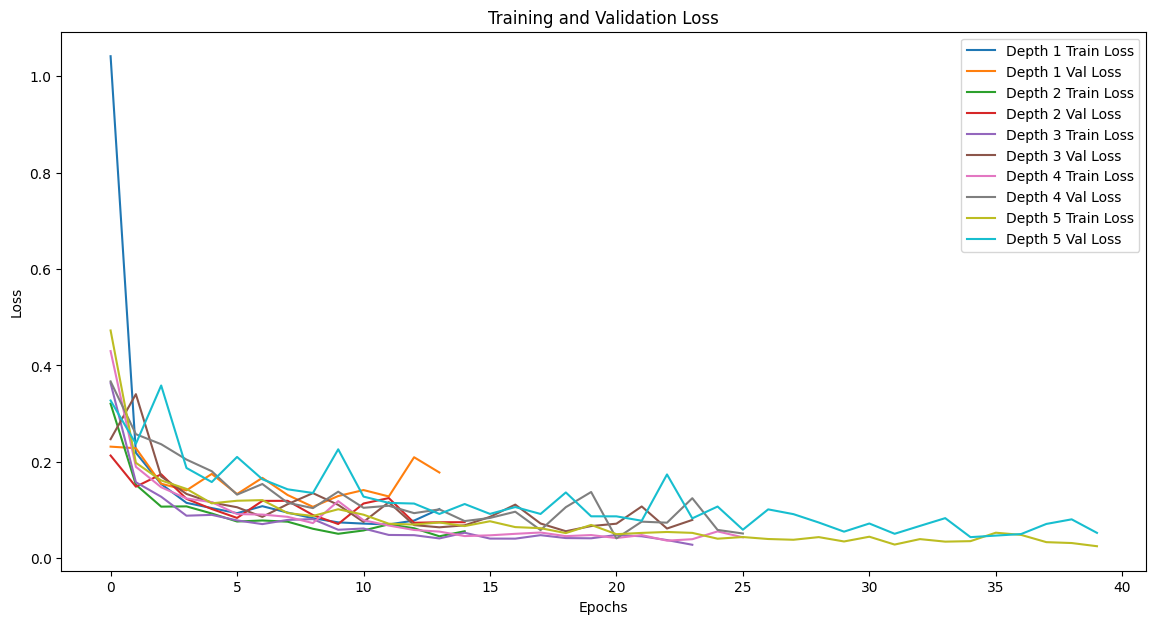

In [ ]:
# Plot training and validation loss for each depth
plt.figure(figsize=(14, 7))
for depth in range(1, 6):  # Example depths
    history = load_history(depth,history_path)
    plt.plot(history['loss'], label=f'Depth {depth} Train Loss')
    plt.plot(history['val_loss'], label=f'Depth {depth} Val Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

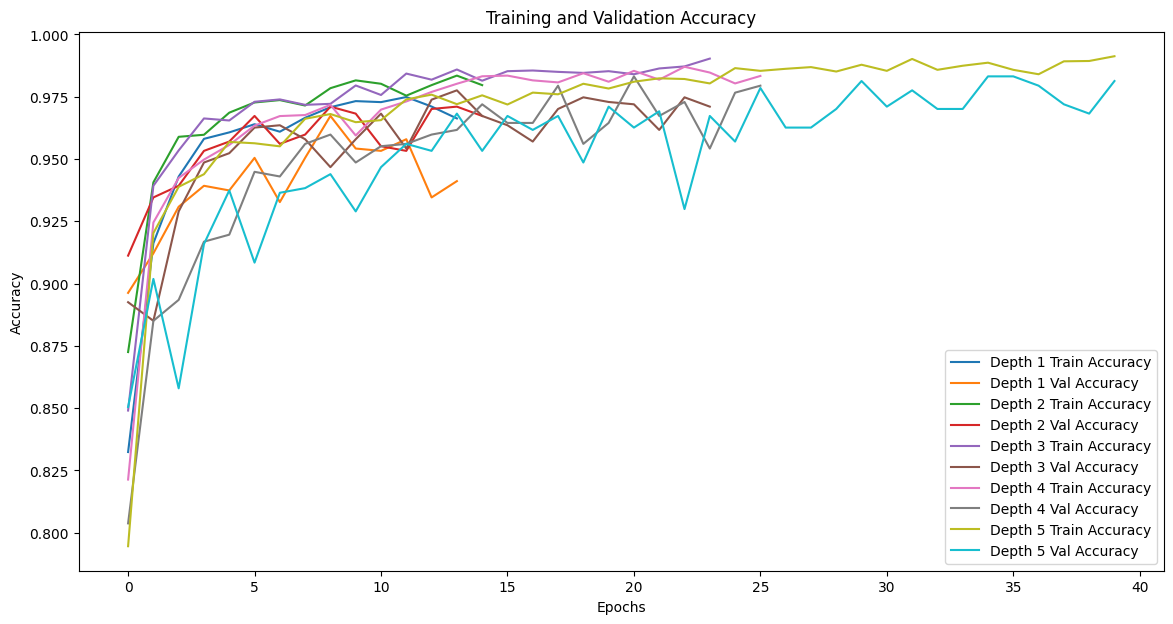

In [ ]:
# Plot training and validation accuracy for each depth
plt.figure(figsize=(14, 7))
for depth in range(1, 6):  # Example depths
    history = load_history(depth,history_path)
    plt.plot(history['accuracy'], label=f'Depth {depth} Train Accuracy')
    plt.plot(history['val_accuracy'], label=f'Depth {depth} Val Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


In [ ]:
# Print test evaluation results for each depth
for depth in range(1, 7):
    history = load_history(depth,history_path)
    print(f"Depth {depth} Test Loss: {history['test_loss']}, Test Accuracy: {history['test_accuracy']}")

Depth 1 Test Loss: 0.08873112499713898, Test Accuracy: 0.9764088988304138
Depth 2 Test Loss: 0.0421382375061512, Test Accuracy: 0.9895150661468506
Depth 3 Test Loss: 0.042532820254564285, Test Accuracy: 0.9882044792175293
Depth 4 Test Loss: 0.0381823405623436, Test Accuracy: 0.9921362996101379
Depth 5 Test Loss: 0.052410632371902466, Test Accuracy: 0.9895150661468506
Depth 6 Test Loss: 0.05816343426704407, Test Accuracy: 0.9842725992202759


Given these results, Depth 4 seems to be the optimal choice as it provides the highest test accuracy and the lowest test loss.

# individual assesment

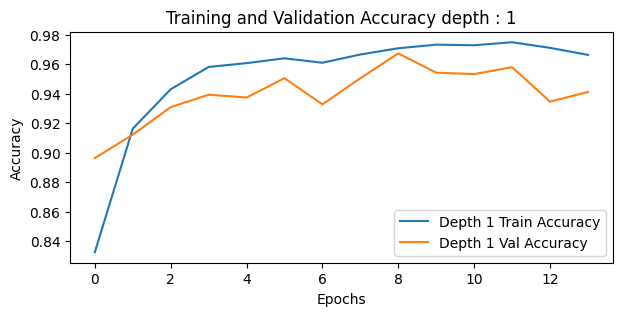

Depth 1 Test Loss: 0.08873112499713898, Test Accuracy: 0.9764088988304138


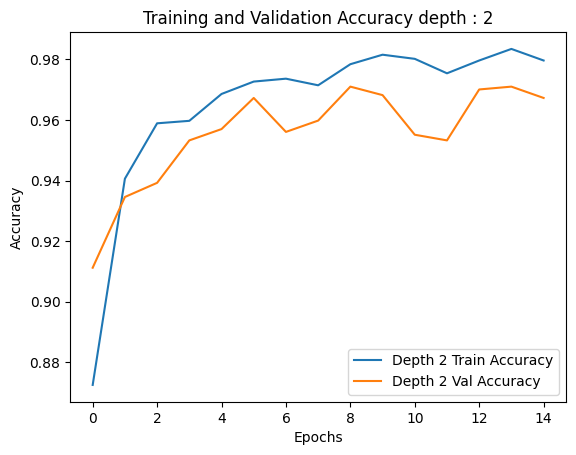

Depth 2 Test Loss: 0.0421382375061512, Test Accuracy: 0.9895150661468506


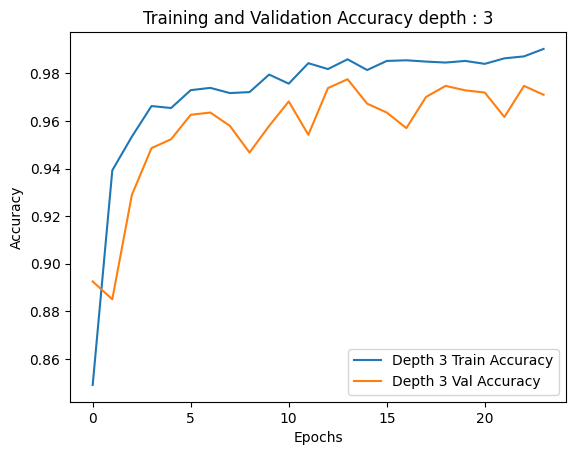

Depth 3 Test Loss: 0.042532820254564285, Test Accuracy: 0.9882044792175293


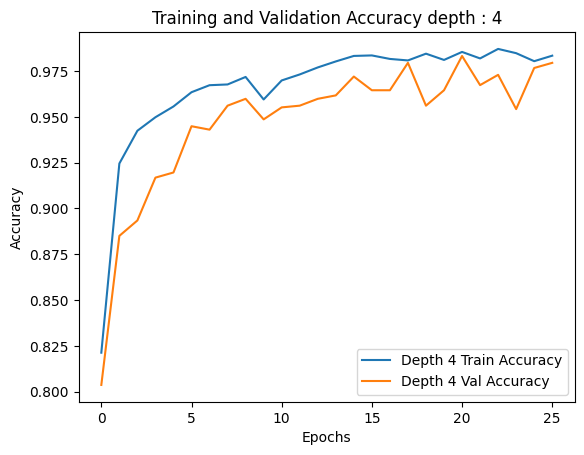

Depth 4 Test Loss: 0.0381823405623436, Test Accuracy: 0.9921362996101379


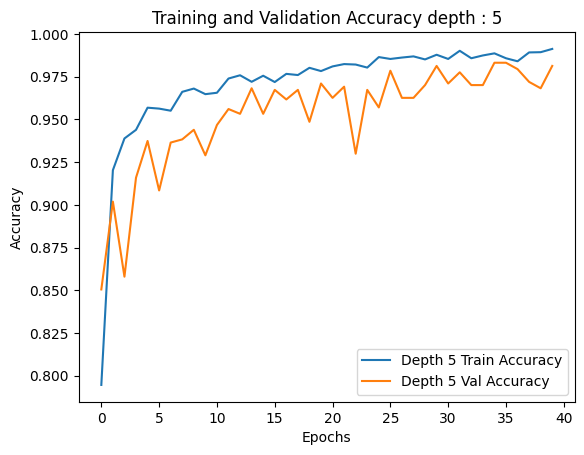

Depth 5 Test Loss: 0.052410632371902466, Test Accuracy: 0.9895150661468506


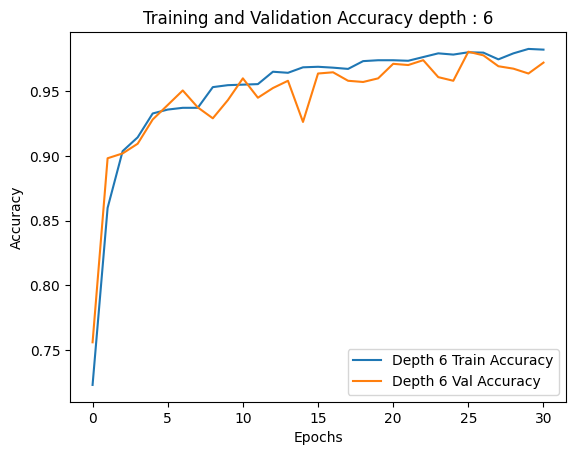

Depth 6 Test Loss: 0.05816343426704407, Test Accuracy: 0.9842725992202759


In [ ]:
# Plot training and validation accuracy for each depth
plt.figure(figsize=(7, 3))
for depth in range(1, 7):  # Example depths
    history = load_history(depth,history_path)
    plt.plot(history['accuracy'], label=f'Depth {depth} Train Accuracy')
    plt.plot(history['val_accuracy'], label=f'Depth {depth} Val Accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Training and Validation Accuracy depth : {depth}')
    plt.show()

    print(f"Depth {depth} Test Loss: {history['test_loss']}, Test Accuracy: {history['test_accuracy']}")

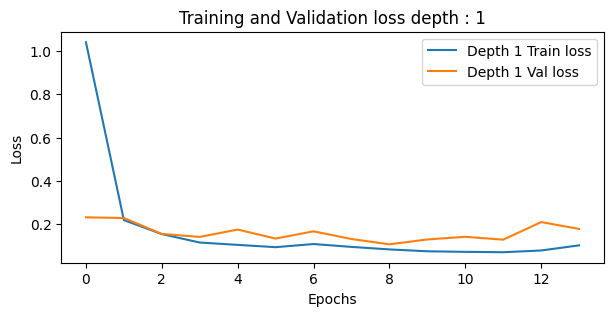

Depth 1 Test Loss: 0.08873112499713898, Test Accuracy: 0.9764088988304138


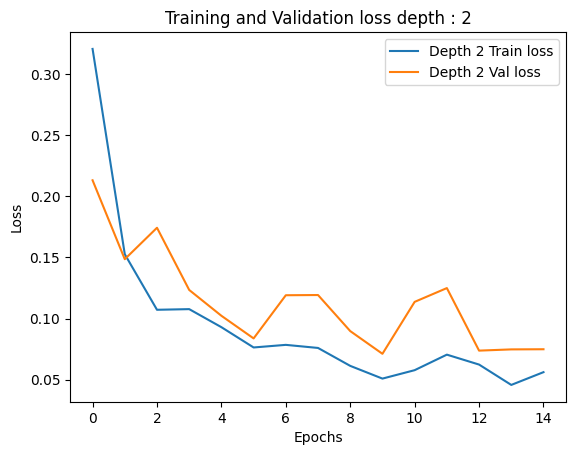

Depth 2 Test Loss: 0.0421382375061512, Test Accuracy: 0.9895150661468506


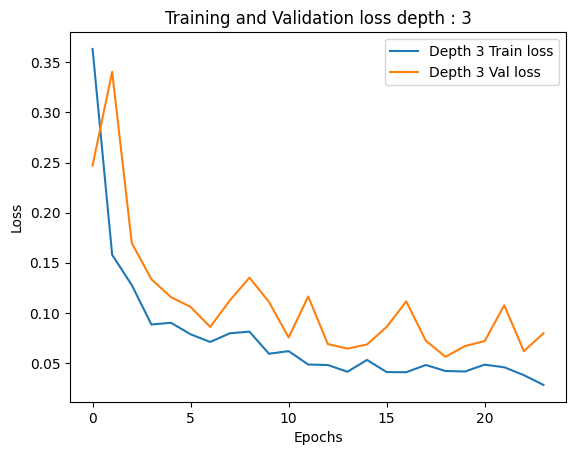

Depth 3 Test Loss: 0.042532820254564285, Test Accuracy: 0.9882044792175293


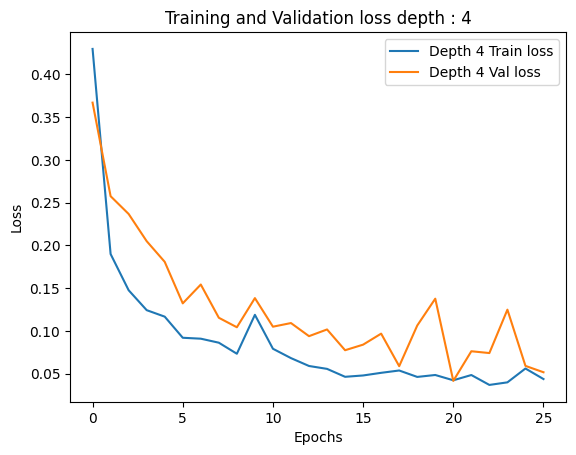

Depth 4 Test Loss: 0.0381823405623436, Test Accuracy: 0.9921362996101379


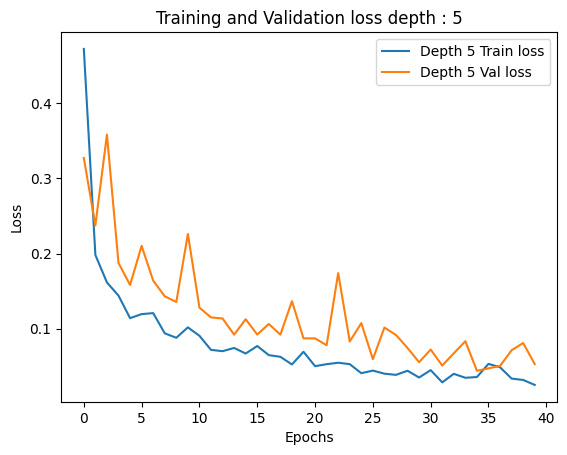

Depth 5 Test Loss: 0.052410632371902466, Test Accuracy: 0.9895150661468506


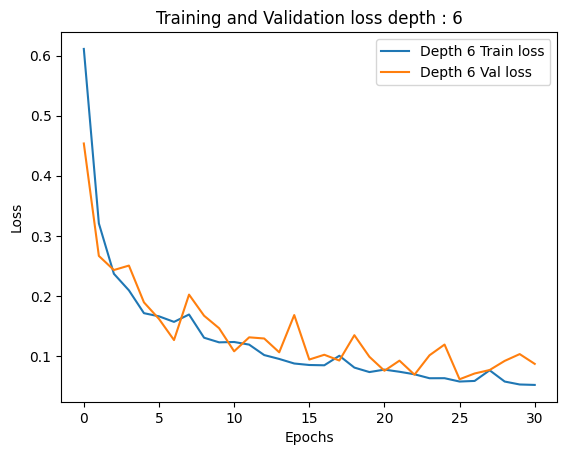

Depth 6 Test Loss: 0.05816343426704407, Test Accuracy: 0.9842725992202759


In [ ]:
# Plot training and validation loss for each depth
plt.figure(figsize=(7, 3))
for depth in range(1, 7):  # Example depths
    history = load_history(depth,history_path)
    plt.plot(history['loss'], label=f'Depth {depth} Train loss')
    plt.plot(history['val_loss'], label=f'Depth {depth} Val loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training and Validation loss depth : {depth}')
    plt.show()

    print(f"Depth {depth} Test Loss: {history['test_loss']}, Test Accuracy: {history['test_accuracy']}")